In [23]:
import importlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns
from sklearn import metrics
import torch

from models import ff, persistent, rnn
from utils import data_utils, data_loader, model_utils, shape_utils

importlib.reload(data_utils)
importlib.reload(data_loader)
importlib.reload(shape_utils)

%matplotlib inline

RUN_FOLDER = "../results/debug/"
NETWORK = "kcm/"
FOLD_MODEL = 4
device = torch.device("cpu")
NUM_WORKERS = 0
HIDDEN_SIZE = 32
BATCH_SIZE = 512

In [24]:
kcm_inputs = data_utils.load_all_inputs(RUN_FOLDER, "kcm/")
atb_inputs = data_utils.load_all_inputs(RUN_FOLDER, "atb/")

# Make dataloaders
kcm_dataloader = data_loader.make_generic_dataloader(
    kcm_inputs['test_data'],
    kcm_inputs['config'],
    BATCH_SIZE,
    data_loader.basic_collate,
    NUM_WORKERS
)
atb_dataloader = data_loader.make_generic_dataloader(
    atb_inputs['test_data'],
    atb_inputs['config'],
    BATCH_SIZE,
    data_loader.basic_collate,
    NUM_WORKERS
)
kcm_dataloader_seq = data_loader.make_generic_dataloader(
    kcm_inputs['test_data'],
    kcm_inputs['config'],
    BATCH_SIZE,
    data_loader.sequential_collate,
    NUM_WORKERS
)
atb_dataloader_seq = data_loader.make_generic_dataloader(
    atb_inputs['test_data'],
    atb_inputs['config'],
    BATCH_SIZE,
    data_loader.sequential_collate,
    NUM_WORKERS
)
_, kcm_mask_seq = data_utils.get_seq_info(kcm_dataloader_seq)
_, atb_mask_seq = data_utils.get_seq_info(atb_dataloader_seq)

# Define embedded variables for nn models
kcm_embed_dict = {
    'timeID': {
        'vocab_size': 1440,
        'embed_dims': 24
    },
    'weekID': {
        'vocab_size': 7,
        'embed_dims': 4
    }
}
# Define embedded variables for nn models
atb_embed_dict = {
    'timeID': {
        'vocab_size': 1440,
        'embed_dims': 24
    },
    'weekID': {
        'vocab_size': 7,
        'embed_dims': 4
    }
}

In [25]:
# Load trained models
kcm_model = ff.FF(
    "FF",
    11,
    HIDDEN_SIZE,
    kcm_embed_dict,
    device
)
kcm_model.load_state_dict(torch.load(f"{RUN_FOLDER}kcm/models/FF_{FOLD_MODEL}.pt"))
kcm_model.eval()
kcm_model_seq = rnn.GRU_RNN(
    "GRU_RNN",
    8,
    1,
    HIDDEN_SIZE,
    BATCH_SIZE,
    kcm_embed_dict,
    device
)
kcm_model_seq.load_state_dict(torch.load(f"{RUN_FOLDER}kcm/models/GRU_RNN_{FOLD_MODEL}.pt"))
kcm_model_seq.eval()

atb_model = ff.FF(
    "FF",
    11,
    HIDDEN_SIZE,
    atb_embed_dict,
    device
)
atb_model.load_state_dict(torch.load(f"{RUN_FOLDER}atb/models/FF_{FOLD_MODEL}.pt"))
atb_model.eval()
atb_model_seq = rnn.GRU_RNN(
    "GRU_RNN",
    8,
    1,
    HIDDEN_SIZE,
    BATCH_SIZE,
    atb_embed_dict,
    device
)
atb_model_seq.load_state_dict(torch.load(f"{RUN_FOLDER}atb/models/GRU_RNN_{FOLD_MODEL}.pt"))
atb_model_seq.eval()

GRU_RNN(
  (loss_fn): MaskedMSELoss(
    (mse_loss): MSELoss()
  )
  (timeID_em): Embedding(1440, 24)
  (weekID_em): Embedding(7, 4)
  (activation): ReLU()
  (rnn): GRU(8, 32, batch_first=True)
  (linear): Linear(in_features=60, out_features=1, bias=True)
)

In [26]:
# Load baseline models
kcm_model_baseline = data_utils.load_pkl(f"{RUN_FOLDER}kcm/models/AVG_{FOLD_MODEL}.pkl")
kcm_model_baseline_seq = data_utils.load_pkl(f"{RUN_FOLDER}kcm/models/PER_TIM_{FOLD_MODEL}.pkl")
atb_model_baseline = data_utils.load_pkl(f"{RUN_FOLDER}atb/models/AVG_{FOLD_MODEL}.pkl")
atb_model_baseline_seq = data_utils.load_pkl(f"{RUN_FOLDER}atb/models/PER_TIM_{FOLD_MODEL}.pkl")
all_results = []

In [27]:
# Test KCM on KCM
train_network = "KCM"
test_network = "KCM"
labels, preds = kcm_model_baseline.predict(kcm_dataloader)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{kcm_model_baseline.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(kcm_model, kcm_dataloader)
labels = data_utils.de_normalize(labels, kcm_inputs['config']['time_mean'], kcm_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, kcm_inputs['config']['time_mean'], kcm_inputs['config']['time_std'])
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{kcm_model.model_name}"
}))
labels, preds = kcm_model_baseline_seq.predict(kcm_dataloader_seq)
preds = data_utils.aggregate_tts(preds, kcm_mask_seq)
labels = data_utils.aggregate_tts(labels, kcm_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{kcm_model_baseline_seq.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(kcm_model_seq, kcm_dataloader_seq, sequential_flag=True)
labels = data_utils.de_normalize(labels, kcm_inputs['config']['time_gap_mean'], kcm_inputs['config']['time_gap_std'])
preds = data_utils.de_normalize(preds, kcm_inputs['config']['time_gap_mean'], kcm_inputs['config']['time_gap_std'])
preds = data_utils.aggregate_tts(preds, kcm_mask_seq)
labels = data_utils.aggregate_tts(labels, kcm_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{kcm_model_seq.model_name}"
}))

In [28]:
# Test KCM on ATB
train_network = "KCM"
test_network = "ATB"
labels, preds = kcm_model_baseline.predict(atb_dataloader)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{kcm_model_baseline.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(kcm_model, atb_dataloader)
labels = data_utils.de_normalize(labels, kcm_inputs['config']['time_mean'], kcm_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, kcm_inputs['config']['time_mean'], kcm_inputs['config']['time_std'])
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{kcm_model.model_name}"
}))
labels, preds = kcm_model_baseline_seq.predict(atb_dataloader_seq)
preds = data_utils.aggregate_tts(preds, atb_mask_seq)
labels = data_utils.aggregate_tts(labels, atb_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{kcm_model_baseline_seq.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(atb_model_seq, atb_dataloader_seq, sequential_flag=True)
labels = data_utils.de_normalize(labels, kcm_inputs['config']['time_gap_mean'], kcm_inputs['config']['time_gap_std'])
preds = data_utils.de_normalize(preds, kcm_inputs['config']['time_gap_mean'], kcm_inputs['config']['time_gap_std'])
preds = data_utils.aggregate_tts(preds, atb_mask_seq)
labels = data_utils.aggregate_tts(labels, atb_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{kcm_model_seq.model_name}"
}))

In [29]:
# Test ATB on ATB
train_network = "ATB"
test_network = "ATB"
labels, preds = atb_model_baseline.predict(atb_dataloader)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_baseline.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(atb_model, atb_dataloader)
labels = data_utils.de_normalize(labels, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model.model_name}"
}))
labels, preds = atb_model_baseline_seq.predict(atb_dataloader_seq)
preds = data_utils.aggregate_tts(preds, atb_mask_seq)
labels = data_utils.aggregate_tts(labels, atb_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_baseline_seq.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(atb_model_seq, atb_dataloader_seq, sequential_flag=True)
labels = data_utils.de_normalize(labels, atb_inputs['config']['time_gap_mean'], atb_inputs['config']['time_gap_std'])
preds = data_utils.de_normalize(preds, atb_inputs['config']['time_gap_mean'], atb_inputs['config']['time_gap_std'])
preds = data_utils.aggregate_tts(preds, atb_mask_seq)
labels = data_utils.aggregate_tts(labels, atb_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_seq.model_name}"
}))

In [30]:
# Test ATB on KCM
train_network = "ATB"
test_network = "KCM"
labels, preds = atb_model_baseline.predict(kcm_dataloader)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_baseline.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(atb_model, kcm_dataloader)
labels = data_utils.de_normalize(labels, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model.model_name}"
}))
labels, preds = atb_model_baseline_seq.predict(kcm_dataloader_seq)
preds = data_utils.aggregate_tts(preds, kcm_mask_seq)
labels = data_utils.aggregate_tts(labels, kcm_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_baseline_seq.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(atb_model_seq, kcm_dataloader_seq, sequential_flag=True)
labels = data_utils.de_normalize(labels, atb_inputs['config']['time_gap_mean'], atb_inputs['config']['time_gap_std'])
preds = data_utils.de_normalize(preds, atb_inputs['config']['time_gap_mean'], atb_inputs['config']['time_gap_std'])
preds = data_utils.aggregate_tts(preds, kcm_mask_seq)
labels = data_utils.aggregate_tts(labels, kcm_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_seq.model_name}"
}))

In [40]:
gen_df = pd.concat(all_results)
gen_df['Residuals'] = abs(gen_df['Labels'] - gen_df['Preds'])
gen_df

,Labels,Preds,Train Network,Test Network,Model,Residuals
0,1866.000000,836.596119,KCM,KCM,AVG,1029.403881
1,1694.000000,949.588862,KCM,KCM,AVG,744.411138
2,1701.000000,927.919048,KCM,KCM,AVG,773.080952
3,1761.000000,927.919048,KCM,KCM,AVG,833.080952
4,1769.000000,855.021570,KCM,KCM,AVG,913.978430
...,...,...,...,...,...,...
16561,147.341583,156.777878,ATB,KCM,GRU_RNN,9.436295
16562,153.445663,161.562210,ATB,KCM,GRU_RNN,8.116547
16563,155.793381,154.232910,ATB,KCM,GRU_RNN,1.560471
16564,175.044678,323.242554,ATB,KCM,GRU_RNN,148.197876


In [32]:
metric_results = gen_df.groupby(['Model','Train Network','Test Network'], as_index=False).apply(lambda x: np.round(np.sqrt(metrics.mean_squared_error(x.Labels, x.Preds)), 2))
metric_results.columns = ["Model","Train Network","Test Network","Metric"]
metric_results['Train-Test-Model'] = metric_results['Train Network']+"_"+metric_results['Test Network']+"_"+metric_results['Model']
metric_results = metric_results.sort_values('Train-Test-Model')
metric_results

,Model,Train Network,Test Network,Metric,Train-Test-Model
0,AVG,ATB,ATB,654.58,ATB_ATB_AVG
4,FF,ATB,ATB,616.08,ATB_ATB_FF
8,GRU_RNN,ATB,ATB,536.50,ATB_ATB_GRU_RNN
12,PER_TIM,ATB,ATB,554.31,ATB_ATB_PER_TIM
1,AVG,ATB,KCM,668.92,ATB_KCM_AVG
5,FF,ATB,KCM,269.73,ATB_KCM_FF
9,GRU_RNN,ATB,KCM,164.87,ATB_KCM_GRU_RNN
13,PER_TIM,ATB,KCM,152.10,ATB_KCM_PER_TIM
2,AVG,KCM,ATB,840.00,KCM_ATB_AVG
6,FF,KCM,ATB,696.62,KCM_ATB_FF


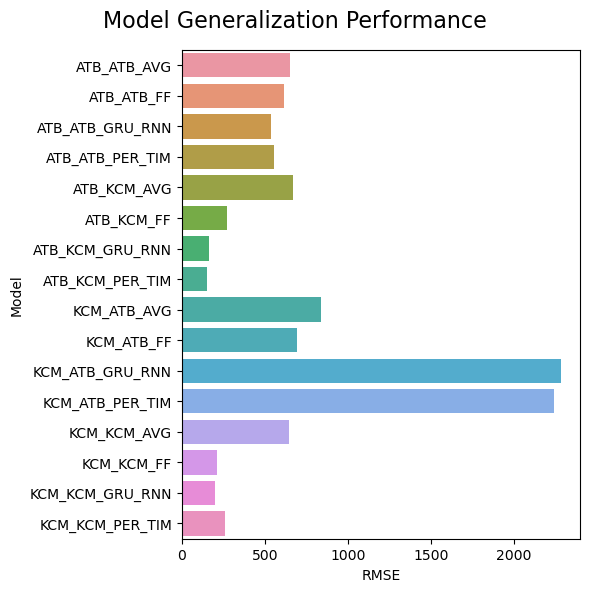

In [33]:
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(6)
sns.barplot(metric_results, x="Metric", y="Train-Test-Model")
axes.set_ylabel("Model")
axes.set_xlabel("RMSE")
fig.suptitle('Model Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_generalization.png", dpi=1800, bbox_inches='tight')

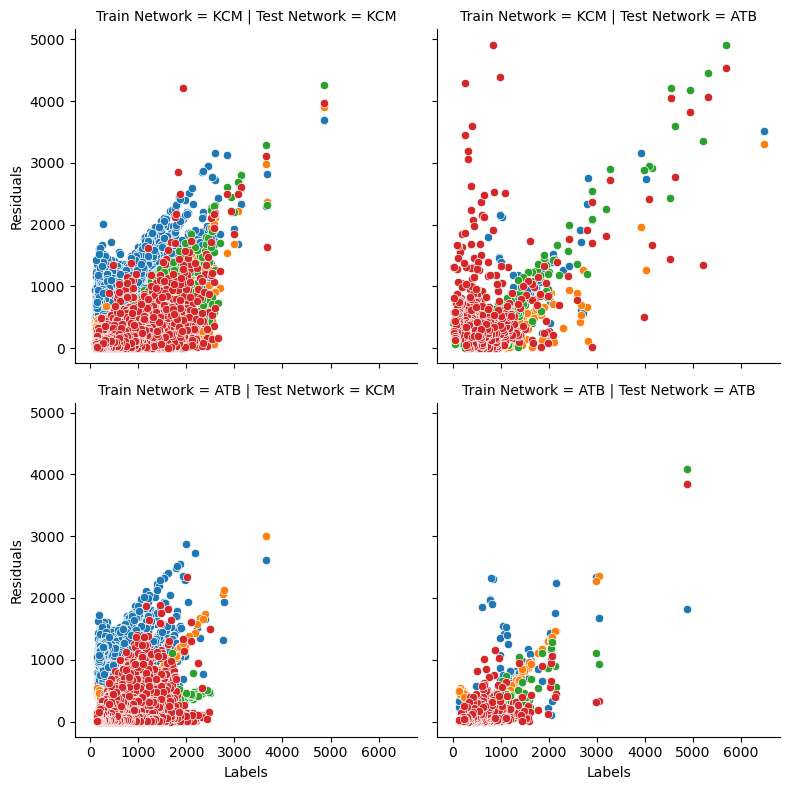

In [43]:
plot_data = gen_df[gen_df['Labels']<10000]
g = sns.FacetGrid(data=plot_data, hue="Model", col="Test Network", row="Train Network", height=4)
g.map(sns.scatterplot, "Labels", "Residuals")
plt.savefig(f"../plots/model_generalization_preds.png", dpi=1800, bbox_inches='tight')